Importing Packages

In [1]:
import pickle
import os
import pandas as pd
import psycopg2
import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Briefly Checking Data

In [2]:
# Specify the desired working directory path
new_directory = r'/Users/jiaml/Documents/Data_Management/Final Project DMS/.bugs'

# Change the working directory using os.chdir()
os.chdir(new_directory)

# For examining pickle file individually
with open('bugzilla_mozzilla_1250.pickle', 'rb') as file:
    data = pickle.load(file)

data

{'classification': 'Components',
 'duplicates': [],
 'url': 'http://members.aol.com',
 'cf_tracking_firefox_relnote': '---',
 'target_milestone': '---',
 'mentors': [],
 'component': 'DOM: HTML Parser',
 'cf_user_story': '',
 'op_sys': 'Windows NT',
 'cf_tracking_firefox115': '---',
 'cf_tracking_thunderbird_esr91': '---',
 'cf_status_firefox_esr102': '---',
 'cf_crash_signature': '',
 'cf_webcompat_priority': '---',
 'is_cc_accessible': True,
 'cf_qa_whiteboard': '',
 'comment_count': 3,
 'resolution': 'DUPLICATE',
 'cf_status_thunderbird_esr91': '---',
 'flags': [],
 'cf_status_firefox115': '---',
 'dupe_of': 1247,
 'cf_fx_points': '---',
 'cf_status_thunderbird_esr102': '---',
 'version': 'Trunk',
 'cf_tracking_thunderbird_esr102': '---',
 'cc': [],
 'is_creator_accessible': True,
 'is_confirmed': True,
 'assigned_to_detail': {'real_name': '',
  'email': 'rickg@formerly-netscape.com.tld',
  'name': 'rickg@formerly-netscape.com.tld',
  'nick': 'rickg',
  'id': 3828},
 'regressions': 

Building Connection with PostgreSQL using psycopg2

In [5]:
# !!!!! Important !!!!!
# Please specify Your Own PostgreSql connection details here
host = 'localhost'
port = '5432'
user = 'postgres'
password = 'cyj112138'  

In [ ]:
# We firstly connected to the default database 'postgres' and create the new database there
# Please do make some changes if you do not have the database in your PostgreSQL 
# Establish a connection
connection = psycopg2.connect(
    host=host,
    port=port,
    dbname='postgres',
    user=user,
    password=password
)

# Disable transaction control temporarily
connection.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

# Create a cursor
cursor = connection.cursor()

new_database_name = 'dbms_fcp'
cursor.execute(f"CREATE DATABASE {new_database_name};")

# Close the cursor and connection
cursor.close()
connection.close()

In [6]:
# Name the database we're going to use
new_database_name = 'dbms_fcp' # DataBaseManagementSystem_FinalCourseProject

In [19]:
# Establish a connection to the new database
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=new_database_name,
    user=user,
    password=password
)

# Create a cursor for the new connection
cursor = conn.cursor()

In [7]:
# Create new schema
new_schema_name = 'bugzilla'
cursor.execute(f"CREATE SCHEMA {new_schema_name};")

conn.commit()

In [8]:
# Create a function to process the datetime object in pickle files
def dateprocessing(x):
    if x is None:
        return None
    ans = datetime.datetime.strptime(str(x), "%Y%m%dT%H:%M:%S").date()
    return ans

Part 1: Table Constructions & Insert Values

    The first table contains the basic information about the bugs 

In [33]:
table1 = 'bugzilla.bug'

cursor.execute(f'CREATE TABLE {table1} (ID int PRIMARY KEY, Status varchar(20), Priority varchar(20), Severity varchar(20), Type varchar(20), Classification varchar(100), platform varchar(50), product varchar(100), component varchar(100), Resolution varchar(100));')

conn.commit()

In [34]:
insert_query = f"INSERT INTO {table1} (ID, Status, Priority, Severity, Type, Classification, platform, product, component, Resolution) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"

pickles = '*.pickle'
pickle_files = glob.glob(pickles)

for each in pickle_files:
    with open(each, 'rb') as file:
        data = pickle.load(file)

    if 'err' in data.keys():
        continue

    values = (data['id'], data['status'], data['priority'], data['severity'], data['type'], data['classification'], data['platform'], data['product'], data['component'], data['resolution'])

    cursor.execute(insert_query, values)

conn.commit()


    Table 2 mainly records the time values in files

In [11]:
table2 = 'bugzilla.time'

cursor.execute(f'CREATE TABLE {table2} (ID int PRIMARY KEY, Creation_Time date, Last_Change_Time date, Last_Resolved_Time date);')

conn.commit()

In [12]:
insert_query = f"INSERT INTO {table2} (ID, Creation_Time, Last_Change_Time, Last_Resolved_Time) VALUES (%s, %s, %s, %s)"

pickles = '*.pickle'
pickle_files = glob.glob(pickles)

for each in pickle_files:
    with open(each, 'rb') as file:
        data = pickle.load(file)

    if 'err' in data.keys():
        continue

    values = (data['id'], dateprocessing(data['creation_time']), dateprocessing(data['last_change_time']), dateprocessing(data.get('cf_last_resolved', None)))

    cursor.execute(insert_query, values)

conn.commit()


    Table 3 contains the information for bugzilla users, naming after 'employee'

In [13]:
table3 = 'bugzilla.employee'

cursor.execute(f"""
    CREATE TABLE {table3} (
        ID int PRIMARY KEY,
        Name varchar(250),
        Nickname varchar(250),
        Email varchar(250),
        Real_Name varchar(250)
    );
""")

conn.commit()

In [14]:
# Prepare insert query
insert_query_details = f"INSERT INTO {table3} (ID, Name, Nickname, Email, Real_Name) VALUES (%s, %s, %s, %s, %s)"

pickle_files = glob.glob('*.pickle')

for each in pickle_files:
    with open(each, 'rb') as file:
        data = pickle.load(file)

    if 'err' in data.keys():
        continue

    # Specifying the keys for us to run a for loop below
    details_keys = ['assigned_to_detail', 'qa_contact_detail', 'creator_detail', 'cc_detail']

    # A for loop for running the 4 detail keys with list within the list
    for key in details_keys:
        detail = data.get(key, None)
        #If the key has values in them and are not empty
        if detail is not None:
            # Handle single dictionary case and list of dictionaries case to a list format
            if type(detail) is dict:
                detail = [detail]

            for person in detail:
                # Check if the ID already exists in the database so that there are no errors from duplicates
                # This part is essential because duplicates violate the sql key value unique constraint and stop the code
                cursor.execute(f"SELECT COUNT(*) FROM {table3} WHERE ID = %s", (person.get('id', None),))
                if cursor.fetchone()[0] > 0:
                    # If the ID already exists, skip this insert operation at the bottom
                    continue

                values_details = (
                    person.get('id', None),    # get( , None) helps us the skip the NA values
                    person.get('name', None),
                    person.get('nick', None),
                    person.get('email', None),
                    person.get('real_name', None)
                )
                cursor.execute(insert_query_details, values_details)

conn.commit()

    Table 4 contains the assigness, creators and votes for each bug

In [15]:
# The people table

table4 = 'bugzilla.involver'

cursor.execute(f"""
    CREATE TABLE {table4} (
        ID int PRIMARY KEY,
        Assignee varchar(250),
        Creator varchar(250),
        Votes int
        );
""")

conn.commit()

In [16]:
insert_query = f"""
    INSERT INTO {table4} (
        ID, Assignee, Creator, Votes
    ) 
    VALUES (%s, %s, %s, %s)
"""

pickle_files = glob.glob('*.pickle')

for each in pickle_files:

    with open(each, 'rb') as file:
        data = pickle.load(file)

    if 'err' in data.keys():
        continue
    
    values = (
        data.get('id', None),    
        data.get('assigned_to', None),
        data.get('creator', None),
        data.get('votes', None)
    )

    cursor.execute(insert_query, values)

conn.commit()


    Table 5 contains the history of changes in bug information over the time. It contains many interesting information there

In [17]:
table5 = 'bugzilla.history'

cursor.execute(f'CREATE TABLE {table5} (ID int, Editor varchar(100), Edit_Date date, Changes_Added varchar(100000), Changes_Field varchar(500), Changes_Removed varchar(100000));')

conn.commit()

In [18]:
insert_query = f"INSERT INTO {table5} (ID, Editor, Edit_date, Changes_Added, Changes_Field, Changes_Removed) VALUES (%s, %s, %s, %s, %s, %s)"

pickles = '*.pickle'
pickle_files = glob.glob(pickles)

for each in pickle_files:

    with open(each, 'rb') as file:
        data = pickle.load(file)

    if 'err' in data.keys():
        continue

    bug_id = data['bugs'][0]['id']

    for each in data['bugs'][0]['history']:

        editors = each['who']
        edited_time = dateprocessing(each['when'])

        for changes in each['changes']:

            added = changes['added']

            if isinstance(added,str) == False:
                added = str(dateprocessing(added))

            fn = changes['field_name']

            if 'removed' in changes.keys():
                removed = changes['removed']
            else:
                removed = ''

            if isinstance(removed,str) == False:
                removed = str(dateprocessing(removed))
    
            values = (bug_id,editors,edited_time,added,fn,removed)
            cursor.execute(insert_query, values)

conn.commit()
    

In [19]:
# In table 1 (the bug table), there are categories both in symbols and text.
# The codes below convert the text to categories based on the description on the website of mozzilla.

query = '''
UPDATE bugzilla.bug
SET severity = 'S4'
WHERE severity IN ('trivial', 'minor');
'''
cursor.execute(query)
query = '''
UPDATE bugzilla.bug
SET severity = 'S3'
WHERE severity = 'normal';
'''
cursor.execute(query)
query = '''
UPDATE bugzilla.bug
SET severity = 'S2'
WHERE severity = 'major';
'''
cursor.execute(query)
query = '''
UPDATE bugzilla.bug
SET severity = 'S1'
WHERE severity IN ('blocker', 'critical');
'''
cursor.execute(query)

conn.commit()

Part 2: Data Exploration

    i) Data Overview

C:\Users\dulun\AppData\Local\Temp\ipykernel_15696\3960229867.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql_query(query, conn)
C:\Users\dulun\AppData\Local\Temp\ipykernel_15696\3960229867.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][column].set_xticklabels(df33_grouped[column_name], rotation=45)
C:\Users\dulun\AppData\Local\Temp\ipykernel_15696\3960229867.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][column].set_xticklabels(df33_grouped[column_name], rotation=45)
C:\Users\dulun\AppData\Local\Temp\ipykernel_15696\3960229867.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][column].set_xticklabels(df33_grouped[column_name], rotation=45)
C:\Users\dulun\AppData\Local\Temp\ipyk

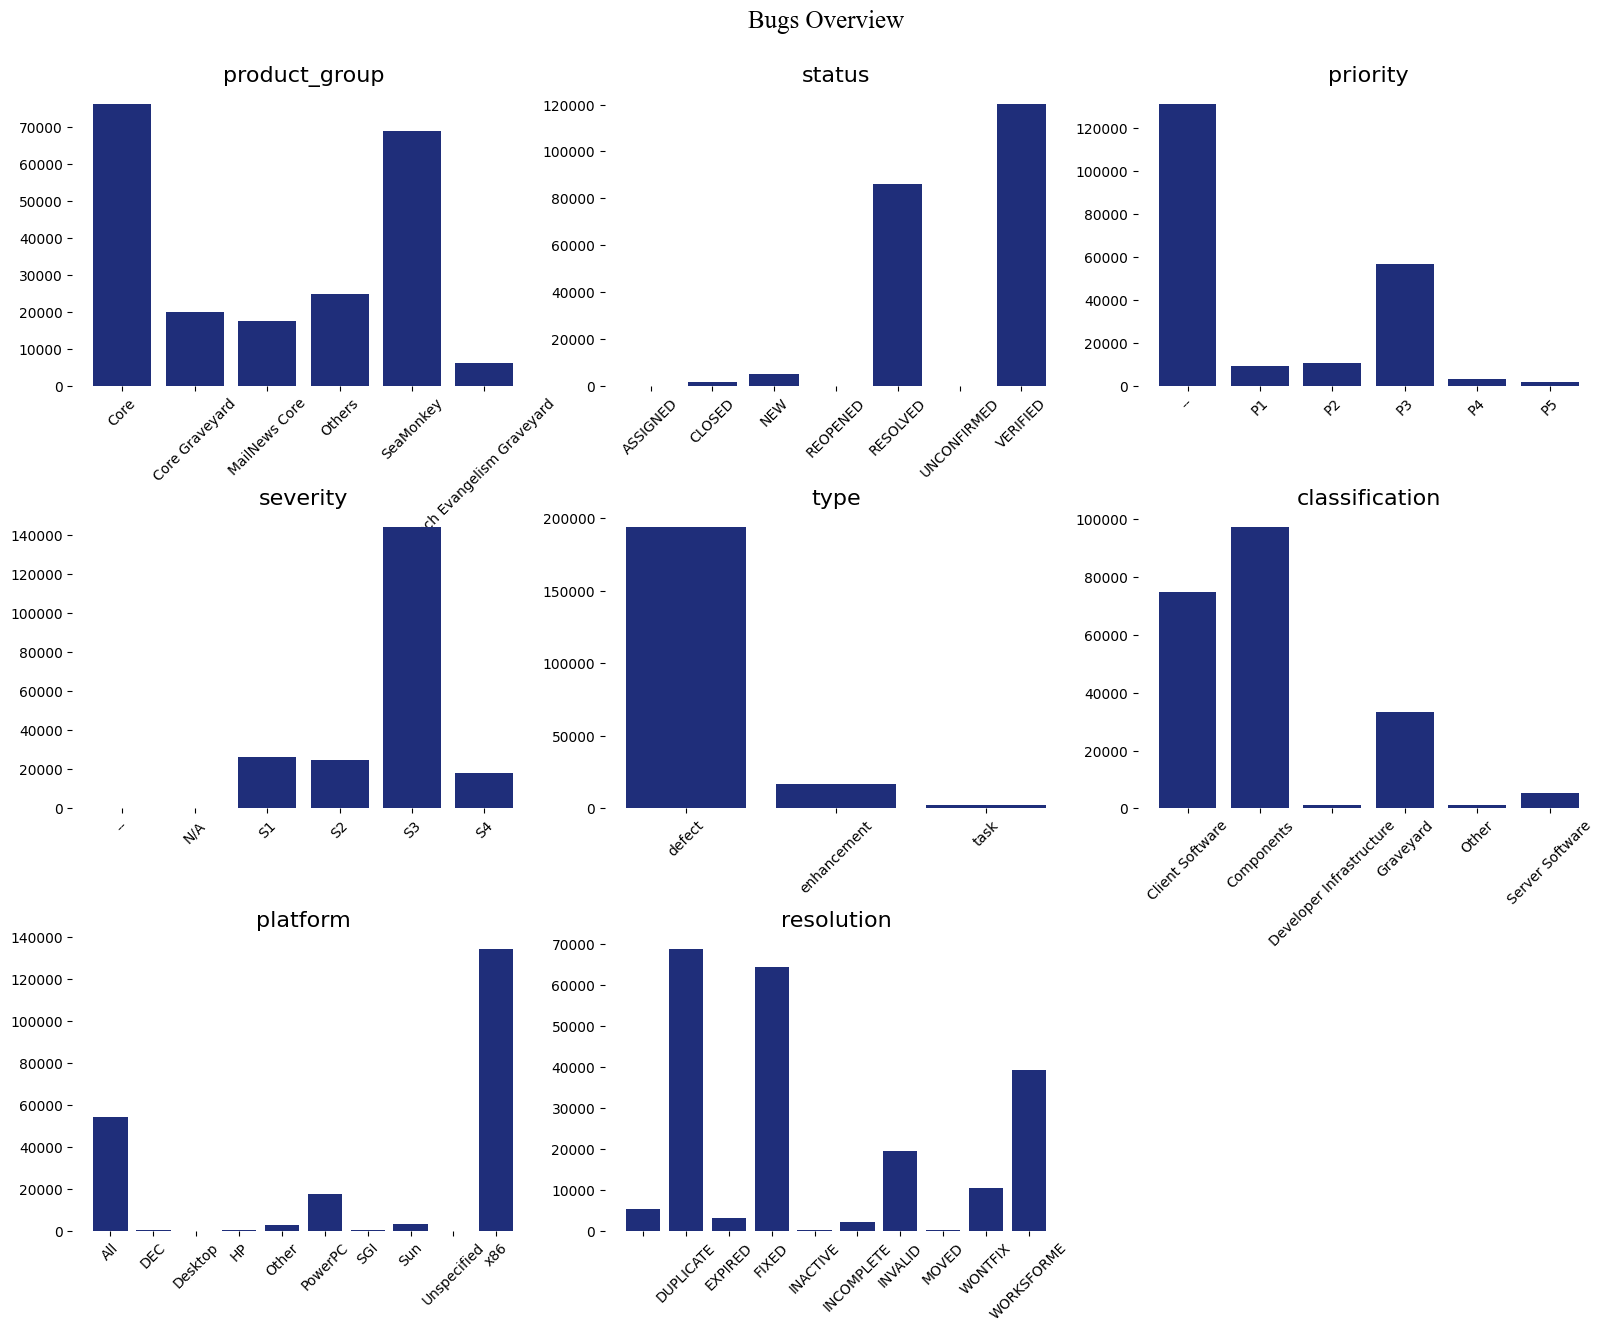

In [9]:
query = '''
SELECT
    CASE WHEN product IN (SELECT product FROM (
                SELECT product, COUNT(*) AS count
                FROM bugzilla.bug
                GROUP BY product
                ORDER BY count DESC
                LIMIT 5
            ) AS top_products) THEN product ELSE 'Others' END AS product_group,
    status, priority, severity, type, classification, platform, resolution, COUNT(*) AS count
FROM bugzilla.bug
GROUP BY product_group, status, priority, severity, type, classification, platform, resolution
ORDER BY count DESC;
'''

# Fetch data from the database and create the DataFrame
df3 = pd.read_sql_query(query, conn)

# Define the figure size
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
fig.tight_layout(w_pad=2.0, h_pad=7.0)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

columns = ["product_group", "status", "priority", "severity", "type", "classification", "platform", "resolution"]

for value in range(len(columns)):
    row = value // 3
    column = value % 3
    
    column_name = columns[value]
    
    df33_grouped = df3.groupby(column_name)['count'].sum().reset_index()
    
    axs[row][column].bar(
        df33_grouped[column_name],
        df33_grouped["count"],
        color=(31/255, 46/255, 122/255)
    )
    axs[row][column].set_xticklabels(df33_grouped[column_name], rotation=45)
    axs[row][column].set_frame_on(False)
    axs[row][column].set_title(column_name, loc="center", fontsize=16)

axs[2][2].axis('off')

fig.suptitle("Bugs Overview", x=0.5, y=1.05, fontsize=18)

plt.show()

    This suite of bar charts provides a concise overview of bug distribution across eight critical aspects, namely 'product_group', 'status', 'priority', 'severity', 'type', 'classification', 'platform', and 'resolution'. It encapsulates the varied dimensions of the bug characteristics, illustrating how bugs are distributed across different product groups, their current statuses, priorities assigned, severity levels, types, classifications, platforms they impact, and their resolution statuses. This visualization serves as a comprehensive snapshot for a quick understanding of the nature and distribution of bugs within the software.

    ii) Time Trends

In [10]:
import calendar
month_mapping = {i: calendar.month_name[i] for i in range(1,13)}

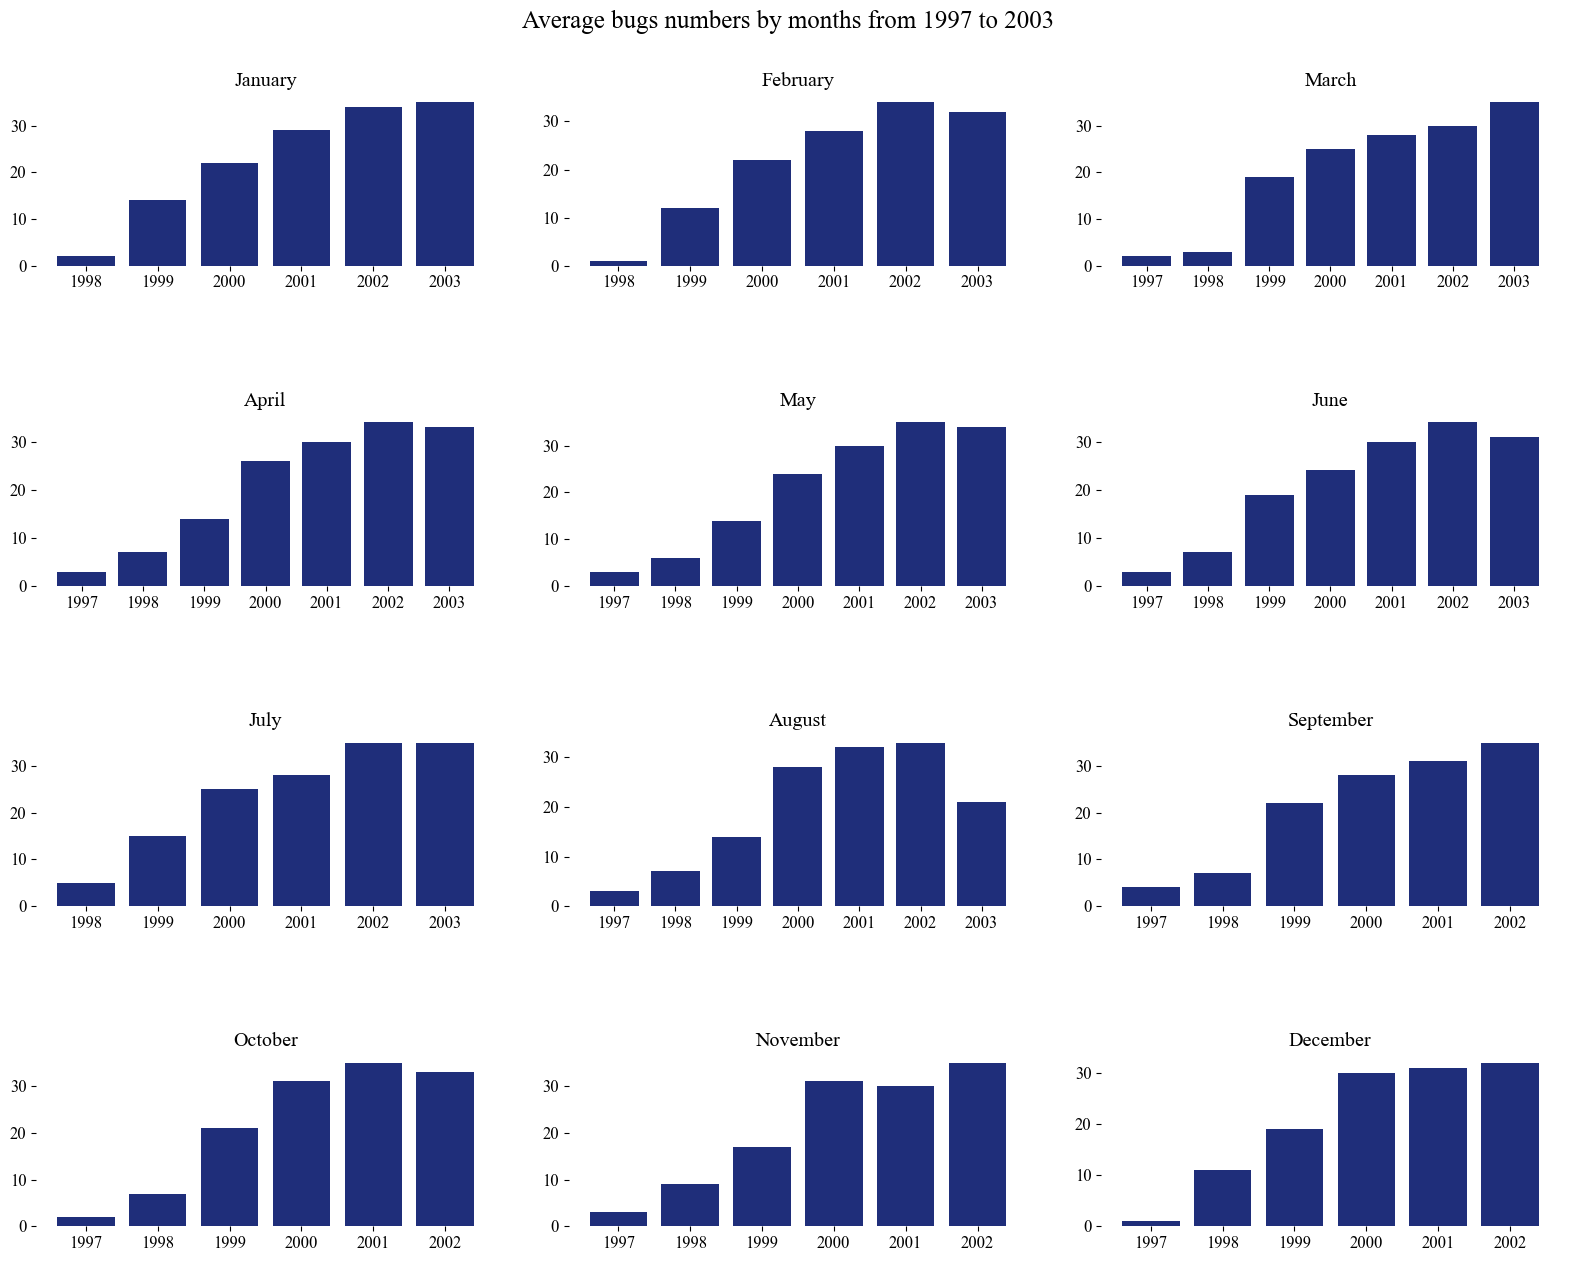

In [11]:
query4 = ''' SELECT
    product, creation_year, creation_month, AVG(num_id) AS AVG_id
FROM
    (SELECT bug.product, 
            EXTRACT(YEAR FROM tim.creation_time) AS creation_year, 
            EXTRACT(MONTH FROM tim.creation_time) AS creation_month, 
            COUNT(*) AS num_id
    FROM bugzilla.bug as bug
    LEFT JOIN bugzilla.time as tim on bug.id = tim.id
    GROUP BY bug.product, EXTRACT(YEAR FROM tim.creation_time), EXTRACT(MONTH FROM tim.creation_time)) AS subquery
GROUP BY product, creation_year, creation_month
ORDER BY creation_year DESC, creation_month DESC;'''
cursor.execute(query4)
conn.commit()
result4 = cursor.fetchall()
column_names = ['product','year','month','avg_id']
df4 = pd.DataFrame(result4,columns=column_names)
df44 = df4.copy()
# Importing calendar module
import calendar

# Creating a mapping from month numbers to names
month_mapping = {i: calendar.month_name[i] for i in range(1,13)}

import warnings
warnings.filterwarnings("ignore")

# Define the figure size
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
fig.tight_layout(w_pad=2.0, h_pad=7.0)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# columns = np.arange(1997, 2004)
df44 = df4.copy()
df44['avg_id'] = df44['avg_id'].astype(float)
df44['month'] = df44['month'].astype(int)
df44 = df44[(df44["year"] >= 1997) & (df44["year"] <= 2003)]

columns = list(np.arange(1, 13))

for value in range(len(columns)):
    
    row = value // 3
    column = value % 3
    
    
    column_name = columns[value]
    
    df44_grouped = df44[df44["month"] == column_name]
    
    df44_grouped = df44_grouped.groupby("year")['avg_id'].count().reset_index()

    
    axs[row][column].bar(
        df44_grouped["year"],
        df44_grouped["avg_id"],
        color = (31/255, 46/255, 122/255)
    )
    axs[row][column].set_frame_on(False)
    
    axs[row][column].set_title(month_mapping[column_name], loc="center")

fig.suptitle("Average bugs numbers by months from 1997 to 2003", x=0.5, y=1.05, fontsize=18)
plt.show()

    This series of bar charts provides an overview of the average number of bug reports per month, year by year, from 1997 to 2003. Each chart corresponds to a specific month, showing the temporal distribution of bugs for that month across the years. This visualization allows us to spot potential trends, irregularities or seasonal effects in bug reporting. It's a crucial tool for understanding the lifecycle of bugs and for devising effective strategies to tackle them.

In [12]:
query = ''' 
SELECT
subquery.product, 
subquery.Type, 
EXTRACT(YEAR FROM subquery.creation_time) AS creation_year, 
SUM(subquery.num_id) AS total_id
FROM
(
    SELECT 
    bug.product, 
    bug.Type, 
    tim.creation_time, 
    COUNT(*) AS num_id
    FROM bugzilla.bug as bug
    LEFT JOIN bugzilla.time as tim on bug.ID = tim.id
    WHERE bug.product IN ('Core', 'SeaMonkey', 'Core Graveyard') AND bug.Type = 'defect'
    GROUP BY bug.product, bug.Type, tim.creation_time
) AS subquery
GROUP BY subquery.product, subquery.Type, creation_year
ORDER BY creation_year DESC; 
'''
cursor.execute(query)
conn.commit()
result = cursor.fetchall()
column_names = ['product','Type','create_year','total_id']
df = pd.DataFrame(result,columns=column_names)


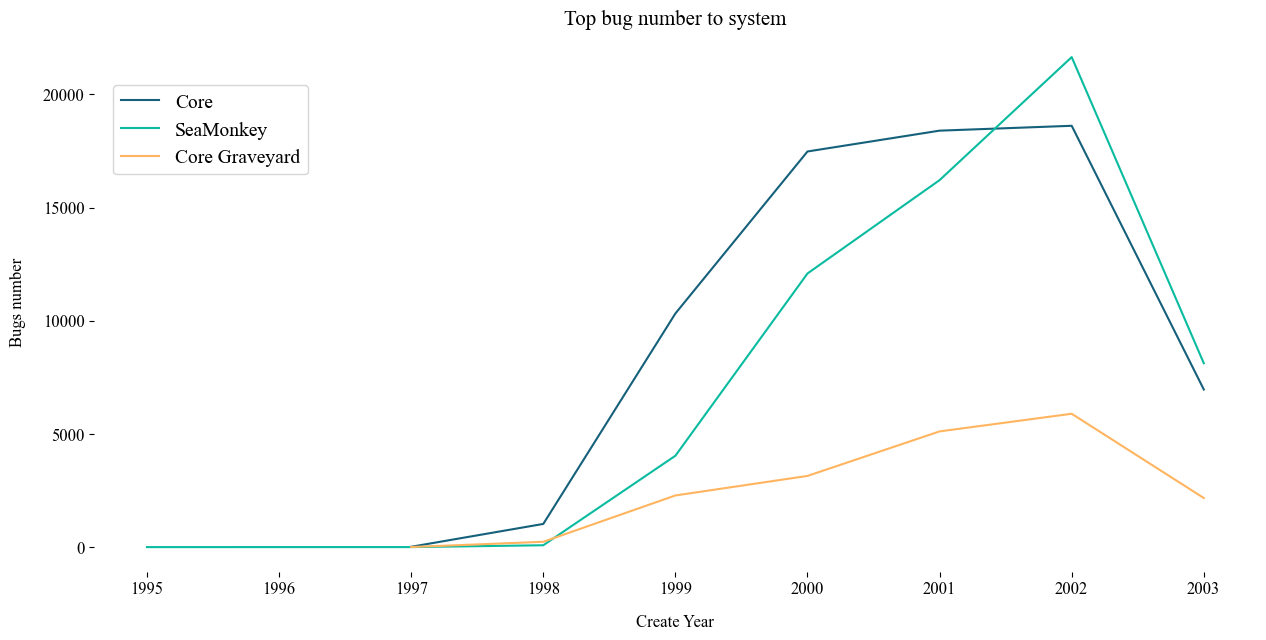

In [13]:
# Define the figure size
fig = plt.figure(figsize=(15, 7))
axs = plt.subplot(111)

axs.set_frame_on(False)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14


# Filter the DataFrame for Core and SeaMonkey separately
core_df = df[df["product"] == "Core"]
sm_df = df[df["product"] == "SeaMonkey"]
coreGV_df =df[df["product"]=='Core Graveyard']

#15607A

#09BB9F

#FFB55F

# Plotting total_id for Core
plt.plot(core_df["create_year"], core_df["total_id"], label="Core", linestyle="solid", color="#15607A")

# Plotting total_id for SeaMonkey
plt.plot(sm_df["create_year"], sm_df["total_id"], label="SeaMonkey", linestyle="solid", color="#09BB9F")

# Plotting total_id for Core Graveyard
plt.plot(coreGV_df['create_year'], coreGV_df['total_id'], label='Core Graveyard', linestyle="solid", color="#FFB55F")

# Adding labels and title
plt.title("Top bug number to system", fontsize=15)
plt.xlabel("Create Year", labelpad=12.0)
plt.ylabel("Bugs number", labelpad=12.0)

# Adding a legend
plt.legend(loc="upper center", bbox_to_anchor=(0.1, 0.92))

# Displaying the graph
plt.show()

    This script efficiently displays the total number of bugs ('total_id') per year ('create_year') across three distinct software products (Core, SeaMonkey, and Core Graveyard) in a line plot. The figure is designed with custom size and font specifications to ensure optimal readability and aesthetics. Each product line is color-coded for clear distinction, and a legend helps identify the products. Detailed labels and title enhance the plot's clarity, making it an efficient tool to understand the bug report trends for these products over time.

In [14]:
query_1 = ''' 
SELECT
subquery.product, 
subquery.Type, 
EXTRACT(YEAR FROM subquery.creation_time) AS creation_year, 
SUM(subquery.num_id) AS total_id
FROM
(
    SELECT 
    bug.product, 
    bug.Type, 
    tim.creation_time, 
    COUNT(*) AS num_id
    FROM bugzilla.bug as bug
    LEFT JOIN bugzilla.time as tim on bug.ID = tim.id
    WHERE EXTRACT(YEAR FROM tim.creation_time) BETWEEN 1999 AND 2003
    AND bug.product IN ('Core', 'SeaMonkey', 'Core Graveyard') AND bug.Type = 'defect'
    GROUP BY bug.product, bug.Type, tim.creation_time
) AS subquery
GROUP BY subquery.product, subquery.Type, creation_year
ORDER BY creation_year DESC; 
'''
cursor.execute(query_1)
conn.commit()
result_1 = cursor.fetchall()
column_names = ['product','Type','create_year','total_id']
df_1 = pd.DataFrame(result_1,columns=column_names)


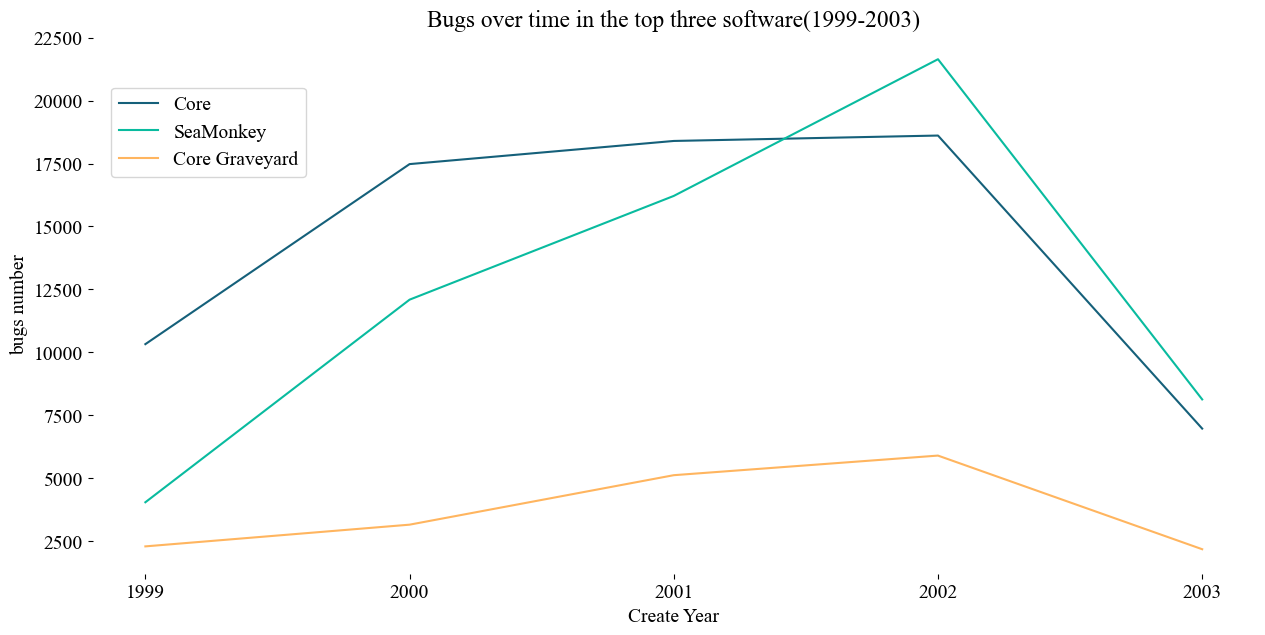

In [15]:
# Define the figure size
fig = plt.figure(figsize=(15, 7))
axs = plt.subplot(111)

axs.set_frame_on(False)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

# Filter the DataFrame for Core, SeaMonkey, and Core Graveyard separately and for the specified years
core_df_1 = df_1[(df_1["product"] == "Core")]
sm_df_1 = df_1[(df_1["product"] == "SeaMonkey")]
coreGV_df_1 = df_1[(df_1['product'] == "Core Graveyard")]

#15607A

#09BB9F

#FFB55F

# Plotting total_id for Core
plt.plot(core_df_1["create_year"], core_df_1["total_id"], label="Core", linestyle="solid", color="#15607A")

# Plotting total_id for SeaMonkey
plt.plot(sm_df_1["create_year"], sm_df_1["total_id"], label="SeaMonkey", linestyle="solid", color="#09BB9F")

# Plotting total_id for Core Graveyard
plt.plot(coreGV_df_1['create_year'], coreGV_df_1['total_id'], label='Core Graveyard', linestyle="solid", color="#FFB55F")

# Adding labels and title
plt.title("Bugs over time in the top three software(1999-2003)")
plt.xlabel("Create Year")
plt.ylabel("bugs number")

# Set the x-axis ticks to show only integer years
plt.xticks(range(1999, 2004))

# Adding a legend
plt.legend(loc="upper center", bbox_to_anchor=(0.1, 0.92))

# Displaying the graph
plt.show()


    This code produces a line plot that visualizes the number of bugs ('total_id') reported per year ('create_year') between 1999 and 2003 for three software products: Core, SeaMonkey, and Core Graveyard. Each product line in the plot is differentiated by a unique color. The x-axis only shows integer years, enabling precise tracking of bug reports. The plot, enhanced with labels, a title, and a legend, offers a clear view of bug trends for these specific software products within the specified timeframe.

    iii) Go Deeper Into History

        Reopened Bugs:
        
        It is found that some bugs reopened after the first time they were resolved. It becomes a major issue since it made the original thinking of 'Time Taken For Each Bug = Last_Resolved_Time - Creation_Time' totally incorrect. 
        
        In this part, it was firstly designed to discover the patterns of reopened bugs.

In [ ]:
# Create another table focusing only on the changes of status when it is either resolved or reopened and the changes of assignees
query = '''
CREATE TABLE bugzilla.bug_fixed_cleaned_history AS
SELECT *,
    LEAD(edit_date) OVER (PARTITION BY id ORDER BY edit_date) AS end_date,
    LEAD(edit_date) OVER (PARTITION BY id ORDER BY edit_date) - edit_date AS days
FROM (
    SELECT *,
        CASE 
            WHEN changes_added = 'NEW' OR changes_added = '{}' THEN 'Pending'
            WHEN changes_added = 'REOPENED' THEN LAG(changes_added,1) OVER (PARTITION BY id ORDER BY edit_date) 
            ELSE changes_added 
        END AS assignee
    FROM (
        SELECT * FROM bugzilla.history 
        WHERE changes_added = 'REOPENED' OR changes_added = 'RESOLVED' OR changes_field = 'assigned_to'
        UNION
        SELECT inv.id, inv.creator as editor, tim.creation_time as edit_date, 'NEW' as changed_added, 'status' as changes_field, '' as changes_removed 
        FROM bugzilla.involver as inv
        LEFT JOIN bugzilla.time as tim ON inv.id = tim.id
    ) AS subquery
    WHERE subquery.id IN (
        SELECT id
        FROM bugzilla.bug
        WHERE resolution = 'FIXED'
    ) 
    AND subquery.id IN (
        SELECT id
        FROM bugzilla.history WHERE changes_removed= 'NEW' GROUP BY id)
    AND subquery.id IN (
        SELECT id
        FROM bugzilla.history WHERE changes_field = 'assigned_to')
    ORDER BY id, edit_date
) AS final;
'''

cursor.execute(query)
conn.commit()


In [25]:
# New table does not have a primary key yet, add a column a history_id which only means the index in this table
query = '''
ALTER TABLE bugzilla.bug_fixed_cleaned_history ADD COLUMN history_id SERIAL;
'''
cursor.execute(query)
conn.commit()

In [26]:
# Make history_id as the primary key
query = '''
ALTER TABLE bugzilla.bug_fixed_cleaned_history ADD CONSTRAINT pk_bug_fixed_cleaned_history PRIMARY KEY (history_id);
'''
cursor.execute(query)
conn.commit()

   reopened_times  frequency
0              15          1
1               3        217
2              17          1
3               5         19
4               4         61


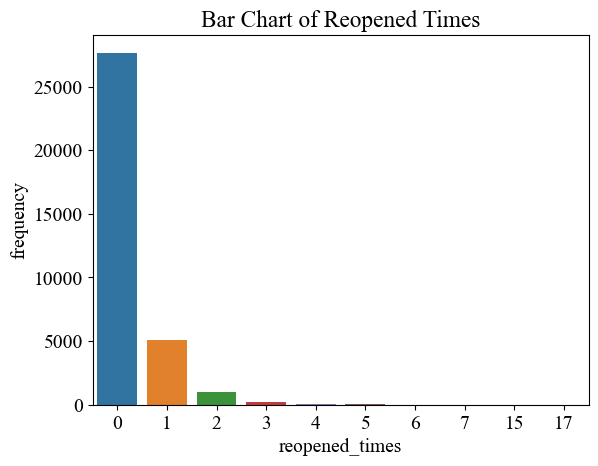

In [20]:
query = '''
WITH frequency_table AS(
	SELECT
		all_ids.id,
		COALESCE(reopened_table.reopened_times, 0) AS reopened_times
	FROM
		(SELECT DISTINCT id FROM bugzilla.bug_fixed_cleaned_history) AS all_ids
	LEFT JOIN
		(SELECT id, COUNT(*) AS reopened_times FROM bugzilla.bug_fixed_cleaned_history WHERE changes_added = 'REOPENED' GROUP BY id) AS reopened_table
	ON
		all_ids.id = reopened_table.id)
SELECT reopened_times, COUNT(*) AS frequency FROM frequency_table GROUP BY reopened_times;
''' 
# COALESCE was used here to include the frequency of 0 in the table
# By default, postgreSQL will remove 0s.
 
cursor.execute(query)
conn.commit()

result = cursor.fetchall()
column_names = ['reopened_times','frequency']
df = pd.DataFrame(result,columns=column_names)
print(df.head())

sns.barplot(x=df['reopened_times'],y=df['frequency'])
plt.title('Bar Chart of Reopened Times')
plt.show()

        The histogram above indicates that reopened bugs are relatively rare in the dataset.

  severity  reopened_times_density
0       S1  0.29363617761407816656
1       S2  0.27834319526627218935
2       S3  0.22297872340425531915
3       S4  0.18969555035128805621


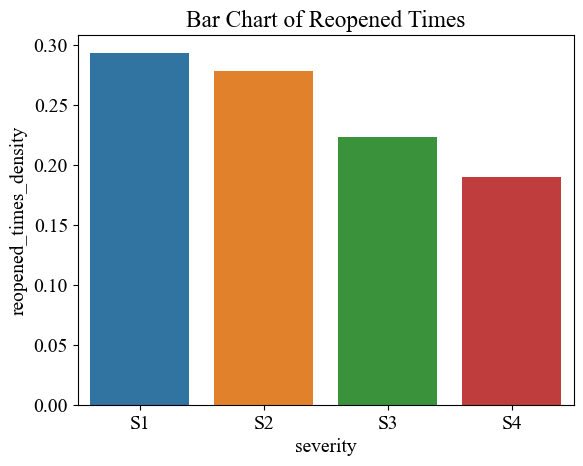

In [21]:
query = '''
SELECT
    subquery.severity,
    SUM(subquery.reopened_times) / COUNT(DISTINCT subquery.id) AS frequency_normalized
FROM
    (
        WITH reopened_table AS (
            SELECT
                all_ids.id,
                COALESCE(reopened_table.reopened_times, 0) AS reopened_times
            FROM
                (SELECT DISTINCT id FROM bugzilla.bug_fixed_cleaned_history) AS all_ids
            LEFT JOIN
                (SELECT id, COUNT(*) AS reopened_times FROM bugzilla.bug_fixed_cleaned_history WHERE changes_added = 'REOPENED' GROUP BY id) AS reopened_table
            ON
                all_ids.id = reopened_table.id
        )
        SELECT
            r.id,
            r.reopened_times,
            b.severity
        FROM
            reopened_table AS r
        LEFT JOIN
            bugzilla.bug AS b ON r.id = b.id
    ) AS subquery
WHERE
    subquery.severity IN ('S1', 'S2', 'S3', 'S4')
GROUP BY
    subquery.severity;
'''
cursor.execute(query)
conn.commit()

result = cursor.fetchall()
column_names = ['severity','reopened_times_density']
df = pd.DataFrame(result,columns=column_names)
print(df.head())

sns.barplot(x=df['severity'],y=df['reopened_times_density'])
plt.title('Bar Chart of Reopened Times')
plt.show()

        It was also checked the reopened times for differnt severity. Since the numbers of bugs in each category are different, density was used here. 
        
        And it can be seen that as the severity level increases (S1 being the highest), it is more likely for a bug to be reopened.

   bug_id  total_pending_days
0      61                 142
1      91                 142
2     118                 146
3     122                 141
4     132                 140


<Axes: xlabel='total_pending_days'>

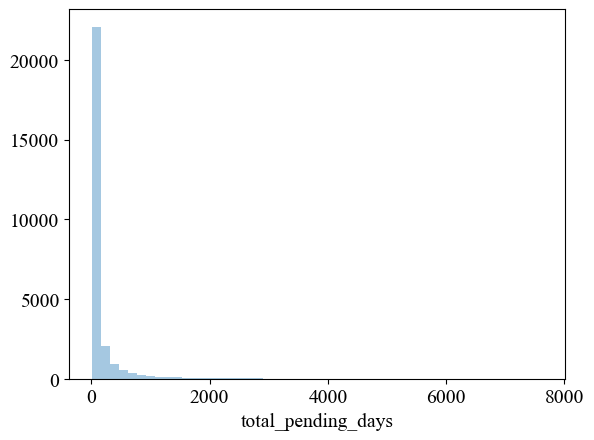

In [22]:
query = '''
WITH days_table AS
    (SELECT d1.history_id, d1.id, d1.edit_date AS start_date, d2.edit_date AS end_date, 
        CASE 
            WHEN d1.changes_added = 'NEW' OR d1.changes_added = '{}' THEN 'Pending' 
            WHEN d1.changes_added = 'REOPENED' THEN LAG(d1.changes_added,1) OVER (ORDER BY d1.history_id)
            ELSE d1.changes_added 
        END AS assignee, 
        (d2.edit_date - d1.edit_date) AS days 
        FROM bugzilla.bug_fixed_cleaned_history AS d1 
    LEFT JOIN 
    bugzilla.bug_fixed_cleaned_history AS d2
    ON 
    d1.history_id + 1 = d2.history_id 
    WHERE d1.changes_added <> 'RESOLVED' AND d1.edit_date < d2.edit_date ORDER BY d1.history_id)
SELECT id, SUM(days) as total_pending_time 
FROM days_table
WHERE assignee = 'Pending'
GROUP BY id, assignee;
'''
cursor.execute(query)
conn.commit()

result = cursor.fetchall()
column_names = ['bug_id','total_pending_days']
df = pd.DataFrame(result,columns=column_names)
print(df.head())

sns.distplot(df['total_pending_days'], kde=False, bins=50)

        Another very interesting fact in the data is that bugs were not taken once they were reported. Bugs had to wait for some time to be assigned. 
        
        The distribution shown above indicated a heavily right-skewed distribution. With most of bugs began being fixed closely to 0 days, while there were also some bugs waited for years to be actually worked on.

In [23]:
query = '''
WITH days_table AS
    (SELECT d1.history_id, d1.id, d1.edit_date AS start_date, d2.edit_date AS end_date, 
        CASE 
            WHEN d1.changes_added = 'NEW' OR d1.changes_added = '{}' THEN 'Pending' 
            WHEN d1.changes_added = 'REOPENED' THEN LAG(d1.changes_added, 1) OVER (ORDER BY d1.history_id)
            ELSE d1.changes_added 
        END AS assignee, 
        (d2.edit_date - d1.edit_date) AS days 
    FROM bugzilla.bug_fixed_cleaned_history AS d1 
    LEFT JOIN bugzilla.bug_fixed_cleaned_history AS d2 ON d1.history_id + 1 = d2.history_id 
    WHERE d1.changes_added <> 'RESOLVED' AND d1.edit_date < d2.edit_date
    ORDER BY d1.history_id
)
SELECT 
    AVG(days) as average_pending_time,
    MIN(days) as minimum,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY days) AS quartile_25,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY days) AS median,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY days) AS quartile_75,
    MAX(days) as maximum
FROM days_table
WHERE assignee = 'Pending';
'''
cursor.execute(query)
conn.commit()

result = cursor.fetchall()
column_names = ['mean','minimum','lower_quartile','median','upper_quartile','maximum']
df = pd.DataFrame(result,columns=column_names)
print(df.head())

                   mean  minimum  lower_quartile  median  upper_quartile   
0  134.3705858526346798        1             2.0    14.0            92.0  \

   maximum  
0     7629  


        Some statistics figures were calcualted here. The mean of pending days is 134.37 days while the median is merely 14 days, again indicating the heavily right-skewed distribution. 
        
        And surprisingly, the maximum of pending days is 7629 days, about 20 years. It is highly likely that the bug had been forgotten. 

    iv) The relation among time taken for bugs and people working on bugs

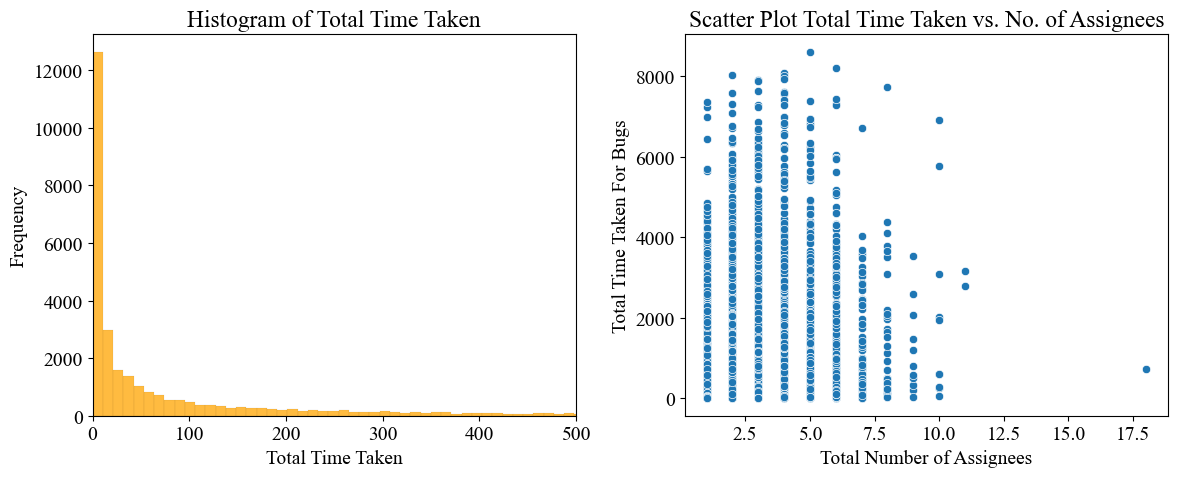

In [24]:
query = '''
SELECT id, 
       COUNT(DISTINCT assignee) AS total_assignees, 
       SUM(days) AS total_time_taken
FROM bugzilla.bug_fixed_cleaned_history
WHERE changes_added LIKE '%@%'
GROUP BY id
HAVING SUM(days) IS NOT NULL
ORDER BY id;
'''
cursor.execute(query)
conn.commit()

result = cursor.fetchall()
column_names = ['id','total_assignees','total_time_taken']
df = pd.DataFrame(result,columns=column_names)

# Create a figure and axis (subplots)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot on the first axis
sns.scatterplot(x=df['total_assignees'], y=df['total_time_taken'], ax=ax[1])

# Labels and title for the scatter plot
ax[1].set_xlabel("Total Number of Assignees")
ax[1].set_ylabel("Total Time Taken For Bugs")
ax[1].set_title("Scatter Plot Total Time Taken vs. No. of Assignees")

# Histogram on the second axis
sns.histplot(df['total_time_taken'], kde=False, color='orange', ax=ax[0])

# Labels and title for the histogram
ax[0].set_xlabel("Total Time Taken")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Histogram of Total Time Taken")
ax[0].set_xlim(0, 500)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

        On the left hand side, it can be observed that most bugs took short time to be fixed with more than 12000 bugs were fixed in the time range from 0 to 10 days. However, the distribution shows a heavy right tail. 
        There is going to be some bugs with excessive amount of time absorbed. 

        On the right, the scatter plot shows a simple illustration about the relationship between total time taken and total number of assignees involved. 
        Most bugs have less than 5 assignees throughout the fixing history, while the portion for bugs with more than 5 assignees is also considerably sufficient. 
        The plot shows a downward trend but not the trend is not evident enough.

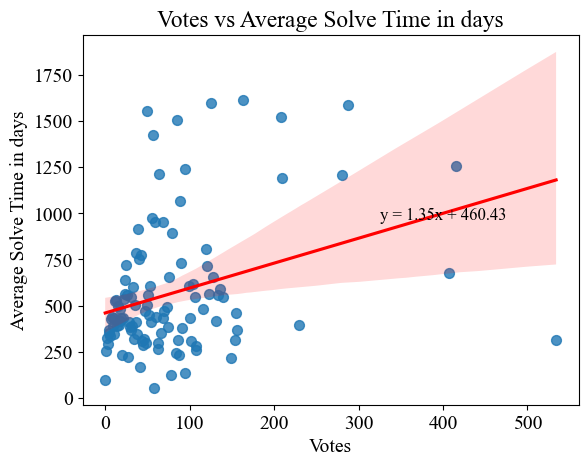

In [25]:
query = '''
    SELECT inv.votes, COUNT(*) AS bug_count, AVG(d1.days) AS avg_solve_time
    FROM
        bugzilla.involver AS inv
        JOIN bugzilla.bug_fixed_cleaned_history AS d1 ON inv.id = d1.id
    WHERE d1.days IS NOT NULL AND d1.changes_added <> 'RESOLVED'
    GROUP BY inv.votes;
'''
cursor.execute(query)
conn.commit()

result = cursor.fetchall()
column_names = ['votes','bug_counts','avg_solve_time']
df = pd.DataFrame(result,columns=column_names)

df['avg_solve_time'] = df['avg_solve_time'].astype(float)

# Create the scatter plot with trendline using Seaborn
sns.regplot(x='votes', y='avg_solve_time', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Get the slope and intercept of the regression line
slope, intercept = np.polyfit(df['votes'], df['avg_solve_time'], deg=1)

# Create the regression equation as a string
regression_equation = f"y = {slope:.2f}x + {intercept:.2f}"

# Set labels and title for the plot
plt.xlabel("Votes")
plt.ylabel("Average Solve Time in days")
plt.title("Votes vs Average Solve Time in days")

# Add the regression equation as text on the plot
plt.text(0.6, 0.5, regression_equation, fontsize=12, transform=plt.gca().transAxes)

# Show the plot
plt.show()



        The above visualization reveals a clear trend: as the number of votes increases, so does the average time to resolve a bug. This indicates that the complexity and time required to solve a bug is likely to attract more attention, and consequently, more votes from the community. 

        More complex bugs tend to intrigue and challenge the community, drawing their attention and votes. These complex bugs, which inherently demand more time to resolve, become a center of interest, inviting engagement from both directly and indirectly involved parties. 

        However, while our data does suggest a relationship between resolution time and vote count, it's crucial to remember that this trend could be influenced by additional factors. A more comprehensive analysis would be required to fully understand the intricate dynamics at play. The correlation observed provides an interesting starting point for further investigations into the matter.


In [26]:
# Close the cursor and connection to quit Q2
cursor.close()
conn.close()

Part 3: Insightful Data Analysis 

A Simple Attempt on the Analysis of Total Time Taken for Bugs By Network Analytics

In [27]:
# Importing packages required for Part 3
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

import networkx as nx
import matplotlib.pyplot as plt

    From the exploration in Part 2, analysis on time taken for bugs is considered to be most interesting one. As mentioned earlier, the time taken can not be simply calculated as last_resolved_time minus creation_time. 
    
    Luckily the table generated in Part 2 can be of direct use here. Hence the 'bug_fixed_cleaned_history' is loaded as the first table in PySpark.

In [28]:
# Building the connection between Spark and Postgre
spark_postgre = SparkSession \
    .builder \
    .appName("last_dance_postgre") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .getOrCreate()

jdbc_url = f"jdbc:postgresql://{host}:{port}/{new_database_name}"
jdbc_properties = {
    "user": user,
    "password": password,
    "driver": "org.postgresql.Driver"
}

# Read the table from Q2 and carry on with it
df = spark_postgre.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable","bugzilla.bug_fixed_cleaned_history") \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.createOrReplaceTempView("table")

# Show the table 
data_sql = spark_postgre.sql(
    '''
    SELECT *
    FROM table
    WHERE assignee LIKE '%@%';
    '''
)
data_sql.show()

+---+--------------------+----------+--------------------+-------------+--------------------+--------------------+----------+----+----------+
| id|              editor| edit_date|       changes_added|changes_field|     changes_removed|            assignee|  end_date|days|history_id|
+---+--------------------+----------+--------------------+-------------+--------------------+--------------------+----------+----+----------+
| 61|   terry@mozilla.org|1998-08-27| blythe@netscape.com|  assigned_to|  nobody@mozilla.org| blythe@netscape.com|1998-10-09|  43|         2|
| 61|blythe@formerly-n...|1998-10-09|   danm@netscape.com|  assigned_to| blythe@netscape.com|   danm@netscape.com|1998-10-15|   6|         3|
| 91|   terry@mozilla.org|1998-08-27| mccabe@netscape.com|  assigned_to|  nobody@mozilla.org| mccabe@netscape.com|1998-09-14|  18|         6|
| 91|mike+mozilla@meer...|1998-09-14|    mlm@netscape.com|  assigned_to| mccabe@netscape.com|    mlm@netscape.com|1999-02-18| 157|         7|
| 91|d

    A network visualisation was applied here so that it is easier to understand the patterns in the network. Noted that, only the fist 2032 rows of history records were used.

In [29]:
assignees = df.select(col("assignee")).distinct().where(col("assignee").isNotNull()).where(col('history_id')<=2032)
assignee_nodes = [row[0] for row in assignees.collect()]

bugs = df.select(col("id")).distinct().where(col("id").isNotNull()).where(col('history_id')<=2032)
bug_nodes = [row[0] for row in bugs.collect()]

relation = df.select(col('id'), col('assignee')).where(col('assignee').like('%@%')).where(col('assignee').like('%@%')).where(col('assignee').isNotNull()).where(col('history_id')<=2032)
edges = [(row[0],row[1]) for row in relation.collect()]


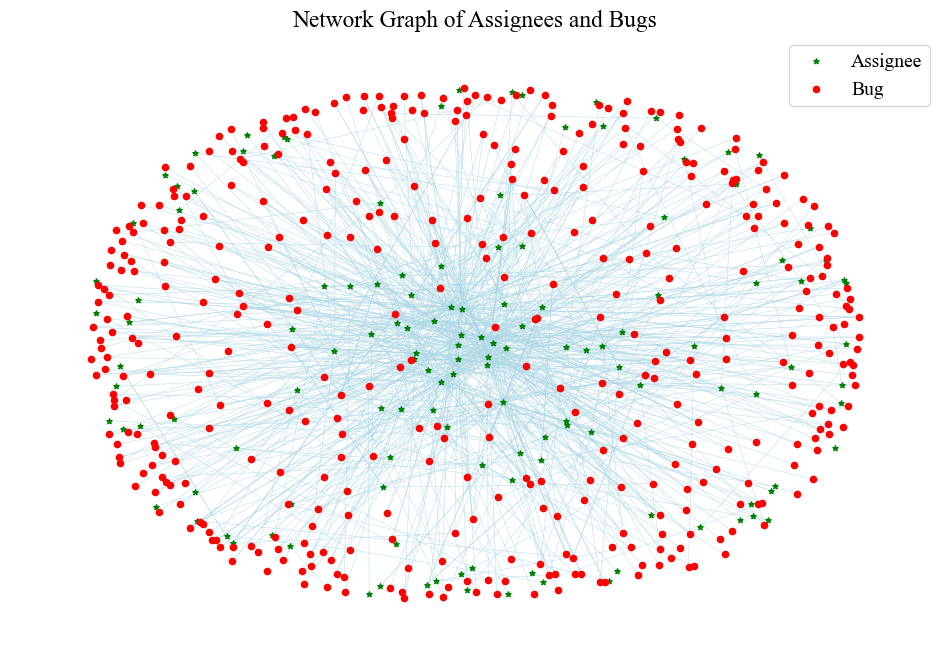

In [30]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes for assignees and bugs
G.add_nodes_from(assignee_nodes, node_type='assignee')
G.add_nodes_from(bug_nodes, node_type='bug')

# Add edges from the 'relation' DataFrame
G.add_edges_from(edges)

# Draw the graph using NetworkX and matplotlib
pos = nx.spring_layout(G, k=0.5, seed=42)

plt.figure(figsize=(12, 8))

# Specify colors for the assignee and bug nodes
nx.draw_networkx_nodes(G, pos, nodelist=assignee_nodes, node_color='green', node_size=15, node_shape='*',label='Assignee')
nx.draw_networkx_nodes(G, pos, nodelist=bug_nodes, node_color='red', node_size=20, label='Bug')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=0.3,edge_color='lightblue')

plt.title("Network Graph of Assignees and Bugs")
plt.legend()
plt.axis('off')
plt.show()

    We firstly created a Assignee to Bug Network. On the graph, it can be observed that some assignees are in the centre of the network while some others in the outer border. However, a two mode network can be difficult to calculate the metric. 
    
    Hence, we projected the two mode network onto a one mode network (Bug to Bug Network) as shown below:

    Noted that, the graph below illustrated all of the bugs and assignees as well as the relations.

In [31]:
# Based the bug_fixed_cleaned_history table, we extracted pairs of assignees who had working together on the same bug.
a2a =  spark_postgre.sql(
    '''
    SELECT t1.assignee AS assignee1, 
    t2.assignee AS assignee2, 
    t1.id AS bug_id
    FROM table t1
    JOIN table t2 
    ON t1.id = t2.id 
    AND t1.assignee <> t2.assignee
    AND t1.assignee LIKE '%@%'
    AND t2.assignee LIKE '%@%';
    '''
)
# We can also use for loop in Python to fulfill the same task, but with PySpark and SQL, it saves huge amount of computational resources.

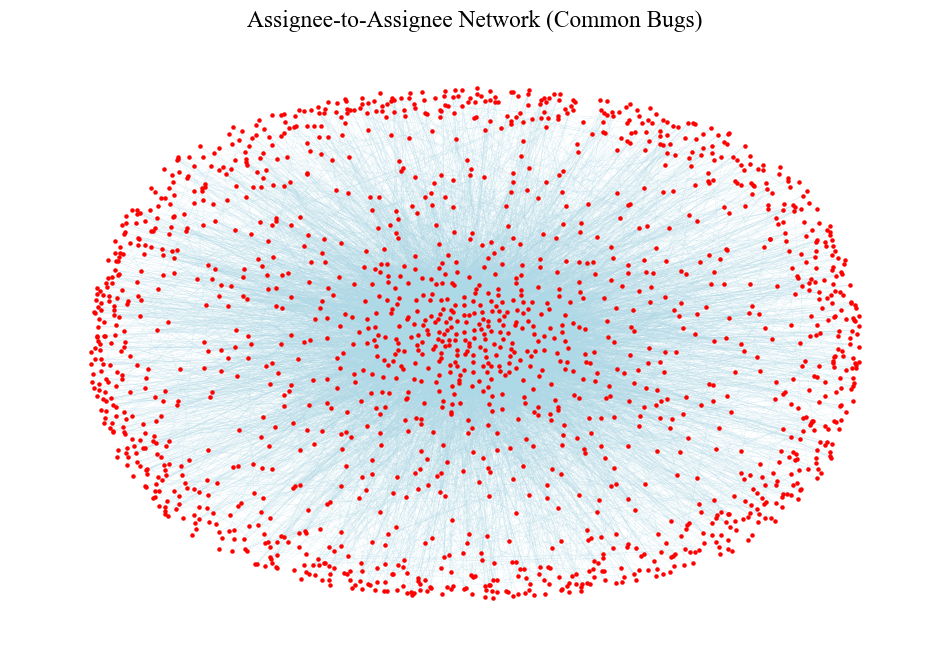

In [32]:
# Convert the Spark DataFrame columns to lists
assignee1_list = a2a.select("assignee1").rdd.flatMap(lambda x: x).collect()
assignee2_list = a2a.select("assignee2").rdd.flatMap(lambda x: x).collect()

# Get unique assignees from both 'assignee1' and 'assignee2' columns
all_assignees = set(assignee1_list).union(set(assignee2_list))

# Create a NetworkX graph
G = nx.Graph()

# Add nodes for assignees
G.add_nodes_from(all_assignees, node_type='assignee')

# Convert DataFrame 'a2a' to a list of edges
edges = [(row['assignee1'], row['assignee2']) for row in a2a.collect()]

# Add edges from the list of edges
G.add_edges_from(edges)

# Draw the graph using NetworkX and matplotlib
pos = nx.spring_layout(G, k=0.5, seed=42)

plt.figure(figsize=(12, 8))

# Specify color for the assignee nodes
nx.draw_networkx_nodes(G, pos, nodelist=all_assignees, node_color='red', node_size=5)

# Draw edges with a reduced width
nx.draw_networkx_edges(G, pos, edge_color='lightblue', width=0.1)

plt.title("Assignee-to-Assignee Network (Common Bugs)")
plt.axis('off')
plt.show()


    The complete network for fixed bugs relations (The edges for A2A network is the common bugs worked)

In [33]:
# Calculate Closeness Centrality
closeness_centralities = nx.closeness_centrality(G)

# Calculate Betweenness Centrality
betweenness_centralities = nx.betweenness_centrality(G)

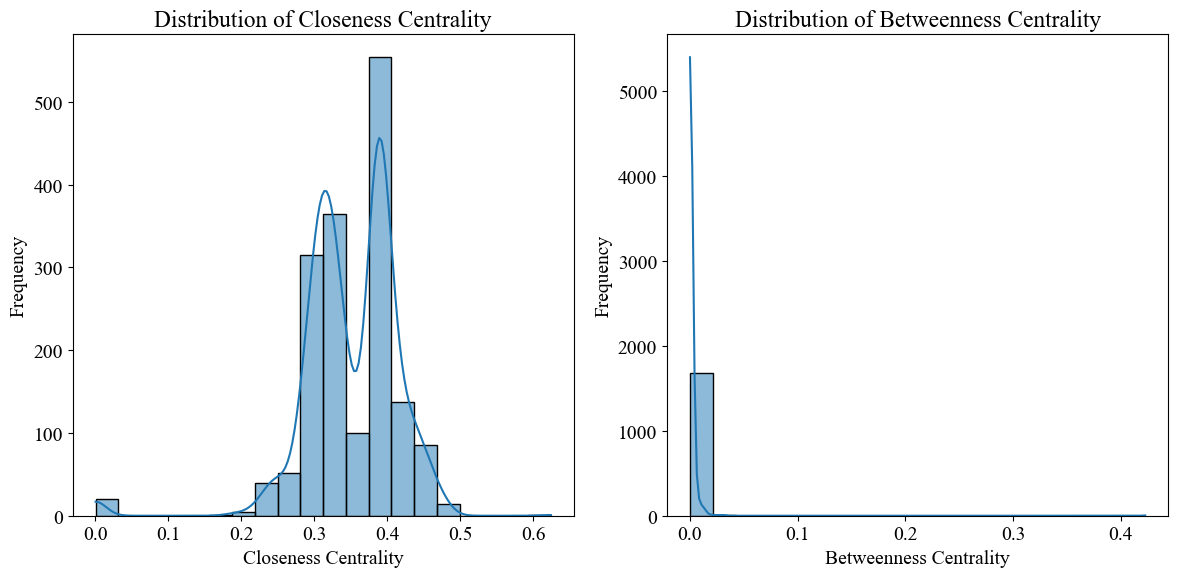

In [34]:
closeness_values = list(closeness_centralities.values())
betweenness_values = list(betweenness_centralities.values())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(closeness_values, bins=20, kde=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Centrality')

plt.subplot(1, 2, 2)
sns.histplot(betweenness_values, bins=20, kde=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Betweenness Centrality')

plt.tight_layout()
plt.show()

    The distributions for closeness centrality and betweenness centrality were also checked. The distribution closeness centrality indicates a bi-model distribution with a huge gap in terms of frequency between 0.3 and 0.4. 

    For betweenness centrality, it can be observed the betweenness centrality is low and close to 0 across the whole network. It indicates that there was limited brokers/bridges in the network.

    In practical tense, most of people were focusing only on small portions of bugs instead of speading their attention to a bigger picture. 

    However, does it mean that betweenness centrality carries no weight in the time takend for bugs?

    A random forest regression was fitted below to check the variable importance.

In [35]:
# Convert centrality dictionaries to pandas DataFrames
closeness_df = pd.DataFrame.from_dict(closeness_centralities, orient='index', columns=['closeness_centrality'])
betweenness_df = pd.DataFrame.from_dict(betweenness_centralities, orient='index', columns=['betweenness_centrality'])

# Create Spark DataFrames from pandas DataFrames
spark_closeness_df = spark_postgre.createDataFrame(closeness_df.reset_index(), ['assignee', 'closeness_centrality'])
spark_betweenness_df = spark_postgre.createDataFrame(betweenness_df.reset_index(), ['assignee', 'betweenness_centrality'])

# Register Spark DataFrames as temporary tables
spark_closeness_df.createOrReplaceTempView("closeness_centralities_table")
spark_betweenness_df.createOrReplaceTempView("betweenness_centralities_table")

# Perform Spark SQL queries on the centralities
spark_postgre.sql("SELECT * FROM closeness_centralities_table").show()
spark_postgre.sql("SELECT * FROM betweenness_centralities_table").show()

+--------------------+--------------------+
|            assignee|closeness_centrality|
+--------------------+--------------------+
|mark@standard8.de...|  0.3923861618130179|
| mloiselle@yahoo.com| 0.33050503757846095|
|    zee@northrock.bm| 0.31744789117191163|
|arai.unmht@gmail.com|  0.3845091286860526|
|   leaf@netscape.com|  0.3758241175658337|
|      rlk@mozdev.org| 0.38703879400635555|
|      bugs@pettay.fi|  0.3883161497621521|
|  grega@netscape.com| 0.30646271763554406|
|bmartin@netscape.com| 0.30470534726064546|
|harishd@netscape.com| 0.46257711521793016|
|jaggernaut@netsca...|  0.4554152909292367|
|installer@seamonk...| 0.32892114762201463|
|cedric.caron@urba...|  0.2387300155494274|
| blake@blakeross.com|  0.3945478101295926|
|    matti@mversen.de| 0.30646271763554406|
|yuta.sugiura@mira...|  0.3012503853860734|
|garywade@desisoft...| 0.34288865680496444|
| maryag@netscape.com|  0.3886826586340371|
|pbaker@where2geti...|  0.2877772724128318|
|david_dick@iprimu...|  0.315744

In [36]:
bug_info = spark_postgre.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable","bugzilla.bug") \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

bug_info.createOrReplaceTempView("bug_info_table")

# Check the contents in the table if wanted
# spark_postgre.sql("SELECT * FROM bug_info_table").show()

In [37]:
query = """
SELECT id, assignee, days
FROM table
WHERE assignee LIKE '%@%'
"""

bug_data_df = spark_postgre.sql(query)

bug_data_df.createOrReplaceTempView("bug_data_temp_table")

# spark_postgre.sql("SELECT * FROM bug_data_temp_table").show()

In [38]:
# Combine all tables above using 3 LEFT JOINS
query = """
SELECT t1.id, t1.days, t1.assignee, tcc.closeness_centrality, tbc.betweenness_centrality, bug.severity
FROM bug_data_temp_table AS t1
LEFT JOIN closeness_centralities_table AS tcc ON t1.assignee = tcc.assignee
LEFT JOIN betweenness_centralities_table AS tbc ON t1.assignee = tbc.assignee
LEFT JOIN bug_info_table AS bug ON t1.id = bug.id
"""

before_regression = spark_postgre.sql(query)

before_regression.createOrReplaceTempView("before_regression_table")

spark_postgre.sql("SELECT * FROM before_regression_table").show()

+---+----+--------------------+--------------------+----------------------+--------+
| id|days|            assignee|closeness_centrality|betweenness_centrality|severity|
+---+----+--------------------+--------------------+----------------------+--------+
| 61|  43| blythe@netscape.com| 0.34054932960327666|  3.675133007302295E-8|      S4|
| 61|   6|   danm@netscape.com|  0.4512978376139861|  0.003570513585701...|      S4|
| 91|  12|clayton@netscape.com|  0.4473756402202741|  0.003139625909775922|      S2|
| 91|   0|clayton@netscape.com|  0.4473756402202741|  0.003139625909775922|      S2|
| 91|  18| mccabe@netscape.com| 0.42107288018687355|  0.002123705716316332|      S2|
| 91| 157|    mlm@netscape.com| 0.32951332412303447|  2.073833289682568...|      S2|
| 91|   9|    mlm@netscape.com| 0.32951332412303447|  2.073833289682568...|      S2|
| 91|  97|    mlm@netscape.com| 0.32951332412303447|  2.073833289682568...|      S2|
| 91|  11|  rickg@netscape.com| 0.44969617998663647|  0.005205405

In [39]:
# Finally, based on the table above, aggregation was performed to get the metrics to be sent into regression models.
# Noted that, average of closeness centrality and betweenness centrality were calculated as a integrated metric for each bug.
# Bugs with higher avg_cc indicates the people working on this bug are more of a crucial role in the whole network
# Bugs with higher avg_bc indicated the people working on this bug are more of a broker/bridge in the whole network
 
query = """
SELECT id, SUM(days) AS total_time_taken, COUNT(*) AS num_assignee, AVG(closeness_centrality) AS avg_cc, AVG(betweenness_centrality) AS avg_bc, severity
FROM before_regression_table
GROUP BY id, severity
HAVING SUM(days) IS NOT NULL;
"""

regression_ready = spark_postgre.sql(query)

regression_ready.createOrReplaceTempView("inputs")

spark_postgre.sql("SELECT * FROM inputs").show()

+------+----------------+------------+-------------------+--------------------+--------+
|    id|total_time_taken|num_assignee|             avg_cc|              avg_bc|severity|
+------+----------------+------------+-------------------+--------------------+--------+
| 43935|             230|           3|  0.461825008908416| 0.01031616300155222|      S3|
| 80451|               3|           2| 0.3915315664691291|0.003822006480140522|      S3|
|137193|             658|           4|  0.443575130886016| 0.01276801387363738|      S1|
| 49331|            2228|           5|0.41334210875829563|0.002428663084658...|      S4|
| 56680|            4596|           3| 0.4113470118480454|0.001151213285936...|      S3|
| 58305|            1246|           3| 0.4464541228053726| 0.00527307699907146|      S3|
| 12046|              16|           3|0.39016144949384973| 5.79848073572766E-4|      S2|
| 71527|               6|           1|  0.437397001404952|0.002769559632916...|      S1|
| 73305|             

R-squared: 0.3280724043332416


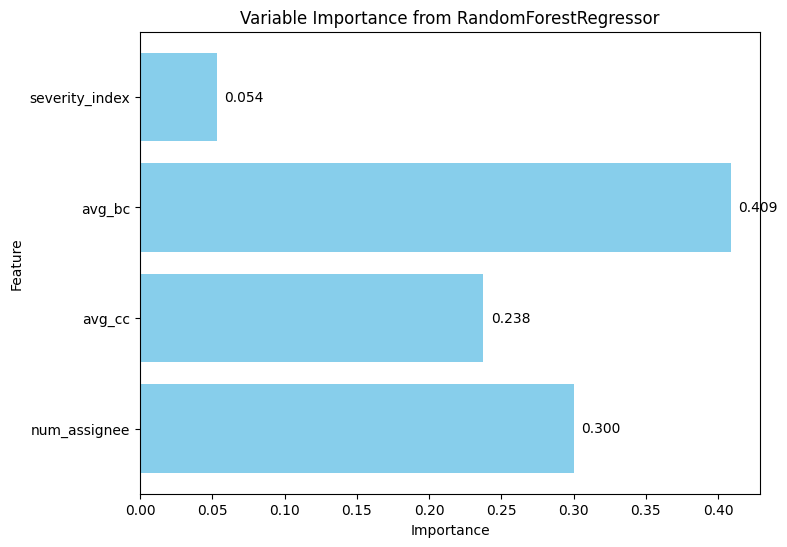

In [24]:
# Create a StringIndexer to convert 'severity' column into numerical values
indexer = StringIndexer(inputCol='severity', outputCol='severity_index')
indexed_data = indexer.fit(regression_ready).transform(regression_ready)

feature_columns = ['num_assignee', 'avg_cc', 'avg_bc', 'severity_index']

# Create a VectorAssembler to assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")
X = assembler.transform(indexed_data)

# Split the data into training and testing sets (80% for training, 20% for testing)
train_data, test_data = X.randomSplit([0.8, 0.2], seed=42)

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(featuresCol="features", labelCol="total_time_taken", seed=10)

# Create a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder().build()

# Create an evaluator to compute the R-squared metric
evaluator = RegressionEvaluator(labelCol="total_time_taken", predictionCol="prediction", metricName="r2")

# Create a TrainValidationSplit to train and validate the model
tvs = TrainValidationSplit(estimator=rf_model, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

# Fit the model to the training data
rf_model = tvs.fit(train_data)

# Make predictions on the testing data
predictions = rf_model.transform(test_data)

# Calculate accuracy (R-squared)
accuracy = evaluator.evaluate(predictions)
print("R-squared:", accuracy)

variable_importance = rf_model.bestModel.featureImportances

feature_names = ['num_assignee', 'avg_cc', 'avg_bc', 'severity_index']

# Plot the variable importance with annotations
plt.figure(figsize=(8, 6))
bars = plt.barh(feature_names, variable_importance, color='skyblue')

for bar, importance in zip(bars, variable_importance):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f"{importance:.3f}",
             ha='left', va='center', color='black')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Variable Importance from RandomForestRegressor')
plt.show()


    Although acting as a broker is not popular among the network, betweenness centrality still matters if the time taken for bugs is wanted to be reduced further. It is a bit surprising to find out that severity does not play a vital role in the task. At the same time, number of assignees involved in the task also carry weights.  

    The random forest model only gives a R squared value of 0.3281, explaining about 32.81% of the variation in the dataset. But it carries valuable insights for a first attempt. To increase the accuracy, more variables should be included in the analysis, like priority, commentors, cc, etc. 

End

In [ ]:
# !!!!! Important !!!!!
# Running following codes will remove the database from your PostgreSql. 
# !!!!! Important !!!!!

# Establish a connection
# connection = psycopg2.connect(
#    host=host,
#    port=port,
#    dbname='postgres',
#    user=user,
#    password=password
# )

# Disable transaction control temporarily
# connection.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

# Create a cursor
# cursor = connection.cursor()

# cursor.execute(f"DROP DATABASE {new_database_name};")

# Close the cursor and connection
# cursor.close()
# connection.close()